# Redes neuronales híbridas cuánticas-clásicas con PyTorch y Qiskit

El aprendizaje automático (ML) se ha establecido como un campo interdisciplinario exitoso que busca extraer matemáticamente información generalizable de los datos (patrones). Incluir la computación cuántica da lugar a interesantes áreas de investigación que buscan aprovechar los principios de la mecánica cuántica para mejorar el proceso de  aprendizaje automático o viceversa. Ya sea que su objetivo sea mejorar los algoritmos de ML clásicos aprovechando las capacidades de cálculos complejos de una computadora cuántica, o bien optimizar algoritmos cuánticos usando arquitecturas de ML clásicas, ambos se encuentran bajo el paraguas del aprendizaje automático cuántico (QML).

En este capítulo, exploramos cómo una red neuronal clásica se puede modificar parcialmente para crear una red neuronal clásica cuántica híbrida. Construiremos un ejemplo simple que integra **Qiskit** con un paquete de software de código abierto de última generación: **[PyTorch](https://pytorch.org/)** . El propósito de este ejemplo es demostrar la facilidad de integrar Qiskit con las herramientas de ML existentes y alentar a los profesionales de ML a explorar lo que es posible con la computación cuántica.

## Contenido

1. [¿Como funciona?](#how)<br> 1.1 [Primero pasos](#prelims)
2. [Entonces, ¿Cómo entra lo Cuántico en escena?](#quantumlayer)
3. [¡Programemos!](#code)<br> 3.1 [Librerías](#imports)<br> 3.2 [Crear una "clase cuántica" con Qiskit](#q-class)<br> 3.3 [Crear una "clase clásica cuántica" con PyTorch](#qc-class)<br> 3.4 [Carga y preprocesamiento de datos](#data-loading-preprocessing)<br> 3.5 [Creando la Red Neuronal Híbrida](#hybrid-nn)<br> 3.6 [Entrenamiento de la Red](#training)<br> 3.7 [Evaluación de la red](#testing)
4. [¿Qué sigue?](#what-now)

## 1. ¿Cómo funciona?<a id="how"></a>

<img src="https://github.com/msluparelli/platypus/blob/main/es/notebooks/ch-machine-learning/hybridnetwork.png?raw=true" class="">

La **figura 1** ilustra el marco que construiremos en este capítulo. En última instancia, crearemos una red neuronal clásica cuántica híbrida que busca clasificar los dígitos dibujados a mano. **Nota**: Aunque no se indique visualmente, las conexiones que se muestran en esta imagen están todas dirigidos hacia abajo. 

### 1.1 Primeros pasos <a id="prelims"></a>

Los conceptos presentados aquí sobre las redes neuronales clásicas se incluyen para destacar las ideas más relevantes y emplear la terminología habitual en esta disciplina. Sin embargo, sigue siendo una aproximación a alto nivel. **Si desea sumergirse un paso más en las redes neuronales clásicas, vea la serie de videos muy bien desarrollados por el youtuber** [3Blue1Brown](https://youtu.be/aircAruvnKk) . Alternativamente, si ya está familiarizado con las redes clásicas, puede [pasar a la siguiente sección](#quantumlayer) .

###### Neuronas y Pesos

Una red neuronal es una arquitectura compuesta de pequeños bloques de construcción llamados neuronas. Una ***neurona*** suele representar una función simple, fácil de calcular y no lineal que asigna una o más entradas a un solo número real. La salida única de una neurona generalmente se copia y actúa como data de entrada a otras neuronas. Gráficamente, representamos las neuronas como nodos en un gráfico y dibujamos conexiones dirigidas al resto de nodos para indicar cómo se usará la salida de una neurona como entrada para otras neuronas (capas). También es importante tener en cuenta que cada conexión en nuestro gráfico se asocia a menudo con un valor escalar llamado [***peso***](https://en.wikipedia.org/wiki/Artificial_neural_network#Connections_and_weights) . La idea aquí es que cada una de las entradas a una neurona se multiplique por un escalar diferente antes de recopilarse y procesarse en un solo valor. El objetivo al entrenar una red neuronal consiste principalmente en elegir nuestros pesos para que la red se comporte de una manera particular.

###### Propagación o alimentación hacia delante

También vale la pena señalar que el tipo particular de red neuronal del que nos ocuparemos se denomina **[red neuronal de alimentación hacia adelante (FFNN)](https://en.wikipedia.org/wiki/Feedforward_neural_network)** . Esto significa que a medida que los datos fluyen a través de nuestra red neuronal, nunca volverán a una neurona que ya visitó. De manera equivalente, se podría decir que el gráfico que describe nuestra red neuronal es un **[grafo acíclico dirigido (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph)** . Además, las neuronas dentro de la misma capa de nuestra red neuronal no tendrán conexiones entre ellas.

###### Estructura de las capas (Entrada y Salida)

La entrada a una red neuronal es un vector clásico (de valor real). Cada componente del vector de entrada se multiplica por un peso diferente y se alimenta a una capa de neuronas de acuerdo con la estructura gráfica de la red. Después de evaluar cada neurona de la capa, los resultados se recopilan en un nuevo vector donde el i-ésimo componente registra la salida de la i-ésima neurona. Este nuevo vector se puede tratar como una entrada para una nueva capa, y así sucesivamente. Usaremos el término estándar ***capa oculta*** para describir todas las capas de nuestra red excepto la primera y la última.


## 2. Entonces, ¿Cómo entra lo Cuántico en escena? <a id="quantumlayer"> </a>

Para crear una red neuronal clásica cuántica, se puede implementar una capa oculta para nuestra red neuronal utilizando un circuito cuántico parametrizado. Por "circuito cuántico parametrizado", nos referimos a un circuito cuántico donde los ángulos de rotación para cada puerta están especificados por los componentes de un vector de entrada clásico. Las salidas de la capa anterior de nuestra red neuronal se recopilarán y utilizarán como entradas para nuestro circuito parametrizado. Las mediciones estadísticas de nuestro circuito cuántico se pueden recopilar y utilizar como entradas para la siguiente capa. A continuación se muestra un simple ejemplo:

<img src="https://github.com/msluparelli/platypus/blob/main/es/notebooks/ch-machine-learning/neuralnetworkQC.png?raw=true" class="">

Aquí, $\sigma$ es una [función no lineal](https://en.wikipedia.org/wiki/Activation_function) y $h_i$ es el valor de la neurona $i$ en cada capa oculta. $R(h_i)$ representa cualquier rotación sobre un ángulo igual a $h_i$ y $y$ es el valor de predicción final generado a partir de la red híbrida.

### ¿Cómo se propaga el error hacia atrás?

Si está familiarizado con el aprendizaje automático clásico, es posible que se pregunte de inmediato *cómo calculamos los gradientes cuando se trata de circuitos cuánticos.* Esto sería necesario para incorporar potentes técnicas de optimización como **[el método del gradiente descendente](https://en.wikipedia.org/wiki/Gradient_descent)** . Aunque se vuelve un poco técnico, en resumen, podemos aceptar que un circuito cuántico es como una caja negra y el gradiente de esta caja negra con respecto a sus parámetros se puede calcular de la siguiente manera:

<img src="quantumgradient.png">

donde $\theta$ representa los parámetros del circuito cuántico y $s$ es un desplazamiento macroscópico. El gradiente es entonces simplemente la diferencia entre nuestro circuito cuántico evaluado en $\theta+s$ y $\theta - s$. Por lo tanto, podemos diferenciar sistemáticamente nuestro circuito cuántico como parte de una rutina de retropropagación más grande. Esta regla para calcular el gradiente de los parámetros del circuito cuántico se conoce como **[la regla de cambio de parámetros](https://arxiv.org/pdf/1905.13311.pdf)** . 

In [2]:
# instala las librerías necesarias para este ejercicio
!pip install torchvision

## 3. ¡Programemos! <a id="code"></a>

### 3.1 Librerías <a id="imports"></a>

Primero, importamos algunas librerías útiles que necesitaremos, incluidos Qiskit y PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

### 3.2 Crear una "clase cuántica" con Qiskit <a id="q-class"></a>

Pondremos nuestras funciones cuánticas de Qiskit en una clase. Primero, especificamos cuántos parámetros cuánticos entrenables y cuántos intentos deseamos usar en nuestro circuito cuántico. En este ejemplo, lo mantendremos simple y usaremos un circuito de 1 qubit con un parámetro cuántico entrenable $\theta$. Por simplicidad, iniciamos manualmente el circuito y usamos una rotación $RY-$ por el ángulo $\theta$ para entrenar la salida de nuestro circuito. El circuito se ve así:

<img src="1qubitcirc.png" width="400">

Para medir la salida en la base $z-$, calculamos la expectativa de $\sigma_\mathbf{z}$. $$\sigma_\mathbf{z} = \sum_i z_i p(z_i)$$ Más adelante veremos cómo todo esto se relaciona con la red neuronal híbrida.

In [6]:
class QuantumCircuit:
    """ 
    Esta clase devuelve una interface simple para
    interactuar con el circuito cuántico
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Definición del circuito ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Calcula las probabilidades para cada estado
        probabilities = counts / self.shots
        # Obtener el valor esperado
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Probemos la implementación

Valor esperado para la rotación pi 0.4


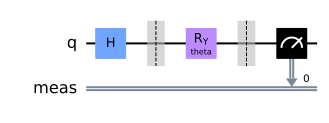

In [7]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Valor esperado para la rotación pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

### 3.3 Crear una "clase clásica cuántica" con PyTorch <a id="qc-class"></a>

Ahora, que nuestro circuito cuántico está definido, podemos crear las funciones necesarias para la retropropagación usando PyTorch. [Los pases hacia adelante y hacia atrás](http://www.ai.mit.edu/courses/6.034b/backprops.pdf) contienen elementos de nuestra clase Qiskit. El pase hacia atrás calcula directamente los gradientes utilizando la fórmula de diferencia finita que presentamos anteriormente.

In [8]:
class HybridFunction(Function):
    """ 
    Definición de la función híbrida cuántica -
    clásica
    """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Propagación hacia adelante """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Propagación hacia atrás """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ 
    Definición de la capa híbrida cuántica -
    clásica
    """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

### 3.4 Carga y preprocesamiento de datos <a id="data-loading-preprocessing"></a>

##### Uniendo todo los pasos:

Crearemos una red neuronal híbrida simple para clasificar imágenes de dos tipos de dígitos (0 o 1) del conjunto de [datos MNIST](http://yann.lecun.com/exdb/mnist/) . Primero cargamos la base de datos MNIST y filtramos las imágenes que contienen 0 y 1. Estos servirán como entradas para que nuestra red neuronal los clasifique.

#### Datos de entrenamiento

In [9]:
# Utilizar las primeras 100 muestras
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Filtrando sólo las etiquetas 0 y 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

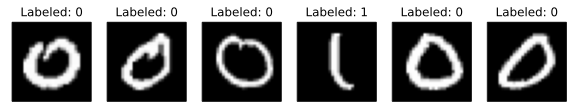

In [10]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

#### Datos de evaluación

In [11]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

Hasta ahora, hemos cargado los datos y codificado una clase que crea nuestro circuito cuántico que contiene 1 parámetro entrenable. Este parámetro cuántico se insertará en una red neuronal clásica junto con los otros parámetros clásicos para formar la red neuronal híbrida. También creamos funciones de propagación hacia atrás y hacia adelante que nos permiten hacer retropropagación y optimizar nuestra red neuronal. Por último, debemos especificar nuestra arquitectura de red neuronal de modo que podamos comenzar a entrenar nuestros parámetros utilizando técnicas de optimización proporcionadas por PyTorch.

### 3.5 Creando la Red Neuronal Híbrida <a id="hybrid-nn"></a>

Usamos PyTorch para crear una arquitectura de red neuronal. La red deberá ser compatible en términos de su dimensionalidad cuando insertemos la capa cuántica (es decir, nuestro circuito cuántico). Dado que en este ejemplo, nuestro circuito cuántico contiene 1 parámetro, debemos asegurarnos de que la red reduzca las dimensiones de las capas hasta el tamaño 1. Creamos una red neuronal convolucional típica con dos capas completamente conectadas al final. El valor de la última neurona de la capa totalmente conectada se introduce como parámetro $\theta$ en nuestro circuito cuántico. La medición del circuito luego sirve como la predicción final para 0 o 1 según lo proporcionado por una medición $\sigma_z$.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)


### 3.6 Entrenamiento de la Red <a id="training"></a>

¡Ya tenemos todos los ingredientes para entrenar nuestra red híbrida! Podemos especificar cualquier [optimizador de PyTorch](https://pytorch.org/docs/stable/optim.html) , [tasa de aprendizaje](https://en.wikipedia.org/wiki/Learning_rate) y [función de costo/pérdida](https://en.wikipedia.org/wiki/Loss_function) para entrenar en múltiples épocas. En este caso, usamos el optimizador de [Adam](https://arxiv.org/abs/1412.6980) , una tasa de aprendizaje de 0.001 y la [función de pérdida de probabilidad logarítmica negativa](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html) .

In [13]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Propagación hacia delante
        output = model(data)
        # Calcular la pérdida
        loss = loss_func(output, target)
        # Propagación hacia atrás
        loss.backward()
        # Optimización de los pesos
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Entrenando [{:.0f}%]\tPérdida: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Entrenando [5%]	        Pérdida: -0.7754
Entrenando [10%]	Pérdida: -0.9334
Entrenando [15%]	Pérdida: -0.9262
Entrenando [20%]	Pérdida: -0.9452
Entrenando [25%]	Pérdida: -0.9504
Entrenando [30%]	Pérdida: -0.9527
Entrenando [35%]	Pérdida: -0.9542
Entrenando [40%]	Pérdida: -0.9645
Entrenando [45%]	Pérdida: -0.9627
Entrenando [50%]	Pérdida: -0.9738
Entrenando [55%]	Pérdida: -0.9745
Entrenando [60%]	Pérdida: -0.9783
Entrenando [65%]	Pérdida: -0.9772
Entrenando [70%]	Pérdida: -0.9828
Entrenando [75%]	Pérdida: -0.9861
Entrenando [80%]	Pérdida: -0.9876
Entrenando [85%]	Pérdida: -0.9840
Entrenando [90%]	Pérdida: -0.9900
Entrenando [95%]	Pérdida: -0.9902
Entrenando [100%]	Pérdida: -0.9902


Muestra el gráfico de entrenamiento

Text(0, 0.5, 'Neg Log Likelihood Loss')

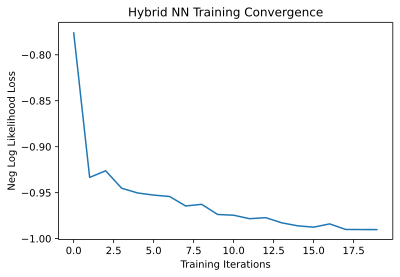

In [14]:
plt.plot(loss_list)
plt.title('Convergencia durante entrenamiento de una Red Nueronal Híbrida')
plt.xlabel('Número de entrenamientos')
plt.ylabel('Pérdida de Probabilidad Logarítmica Negativa')

### 3.7 Evaluación de la red <a id="testing"></a>

In [15]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Comportamiento en datos de evaluación:\n\tPérdida: {:.4f}\n\tPrecisión: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Comportamiento en datos de evaluación:
	Pérdida: -0.9889
	Precisión: 100.0%


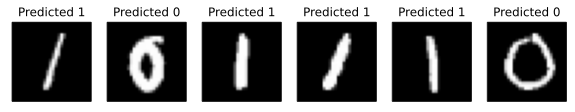

In [16]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

## 4. ¿Qué sigue? <a id="what-now"></a>

#### Si bien es totalmente posible crear redes neuronales híbridas, ¿Realmente tiene algún beneficio?

De hecho, las capas clásicas de esta red se entrenan perfectamente bien (de hecho, mejor) sin la capa cuántica. Además, es posible que haya notado que la capa cuántica que entrenamos aquí **no genera entrelazamiento** y, por lo tanto, seguirá siendo clásicamente simulable a medida que ampliamos esta arquitectura en particular. Esto significa que si espera lograr una ventaja cuántica utilizando redes neuronales híbridas, deberá comenzar extendiendo este código para incluir una capa cuántica más sofisticada.

El objetivo de este ejercicio era reflexionar sobre la integración de técnicas de ML y de computación cuántica para investigar si realmente hay algún elemento de interés en esta disciplina. Gracias a PyTorch y Qiskit, esto es relativamente sencillo.

In [17]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}